# Deep Q-Learning

We can solve Grid World, that's awesome: we have agents that learn! So let's have them learn how to
play Atari video games, such as pong!

But... Grid World has a state space of ~20... Atari games have a state space of ~$10^{17000}$ using
pixels (consider that there are ~$10^{82}$ atoms in the observable universe). Tabular methods don't
scale to such large spaces.

To overcome this limitation, we will use function approximation and approximate the Q function using
neural networks!

**Prerequisites**: Neural Network fundamentals as well as PyTorch basic APIs.

## Gymnasium and Atari Pong

[Gymnasium](https://gymnasium.farama.org/index.html) is an API standard for reinforcement learning,
with a vast collections of environments. Let's use it!

In [1]:
import random
import tempfile

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, RecordVideo

from util.gymnastics import DEVICE, init_random, plot_scores, show_gym_video_recording

In [2]:
# Let's learn Gymnasium! https://gymnasium.farama.org/environments/atari/pong/
def gym_simulate(agent = None):
    """Runs an Atari pong game with our agent passed as input."""
    # We use pong deterministic b/c it is simpler to train.
    # Actions: NOOP, FIRE, RIGHT, LEFT, RIGHTFIRE, LEFTFIRE
    sim_env = gym.make("PongDeterministic-v4", render_mode="rgb_array_list", frameskip=1)
    sim_env = init_random(sim_env)
    sim_env = AtariPreprocessing(sim_env)
    sim_env = RecordVideo(sim_env, tempfile.tempdir, lambda i: i == 0)

    init_position, _ = sim_env.reset() # Reset the environment
    
    first_observation, _, _, _, _ = sim_env.step(1) # Take the first step with action=1 that starts the game.
    
    # To create the state, we stack two observations, that is to have a sense of time/velocity
    #       for the pong game. Hint: use np.stack.
    state = np.stack([init_position, first_observation])

    for _ in range(2_500):
        # Call agent.act if the agent is specified, otherwise use action_space.sample() from
        #       the gym environment to select a random action.
        action = agent.act(state) if agent else sim_env.action_space.sample()
  
        observation, _, terminated, truncated, _ = sim_env.step(action)
        
        # Check for completion, if completed reset the environment.
        if terminated or truncated:
            observation, _ = sim_env.reset()
            
        state = np.stack([state[1], observation])
            

    sim_env.close()

    # Call a convenient utility function to show the video in the notebook as a GIF.
    return show_gym_video_recording()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
  logger.warn(

  logger.warn(



Moviepy - Building video /tmp/rl-video-episode-0.mp4.
Moviepy - Writing video /tmp/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /tmp/rl-video-episode-0.mp4


MoviePy - Building file /tmp/rl-video.gif with imageio.


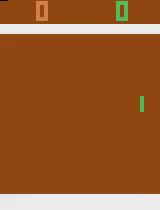

In [3]:
gym_simulate()

## DQN

### Q Function Approximation via Neural Network

Instead of a "lookup" table, $Q$ is going to be a parameterized functions: $Q_\theta(s,a)$. The set
of parameters $\theta$ corresponds to the parameters (e.g., weights) of the neural network trained
to approximate $Q$.

We cannot use the TD error $\delta^{TD}$ to update $Q$ anymore, because we now have to optimize the
set of parameters $\theta$ instead. The target is still the following:
$$
target(s') = R(s, a, s') + \gamma \max_{a'} Q_{\theta_{k}}(s', a')
$$

But now we use gradient descent to update the parameters $\theta$ (in a sense still minimizing
$\delta^{TD}$):
$$
\theta_{k+1} = \theta_k - \alpha \nabla_\theta 
   \biggl\{ \frac{1}{2} \Bigl[ Q_\theta(s,a) - target(s') \Bigr] ^ 2 \biggr\}
$$

Luckily, we don't have to implement any neural networks or know automatic differentiation math
ourselves thanks to modern frameworks like PyTorch, TensorFlow, JAX! We use PyTorch in this course.

In [5]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, action_size):
        super(QNetwork, self).__init__()
        self.conv1 = nn.Conv2d(2,  4, kernel_size=6, stride=2)  # 2x84x84 to 4x40x40
        self.conv2 = nn.Conv2d(4, 16, kernel_size=8, stride=4)  # 4x40x40 to 16x9x9
        self.lsize = 16*9*9
        self.fc1 = nn.Linear(self.lsize, 256)
        self.fc2 = nn.Linear(256, action_size)

    def forward(self, x):
        """Build a network that maps state -> action values."""
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.view(-1, self.lsize)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [6]:
# Test for neural network!
init_random()

test_net = QNetwork(action_size=6)

fake_img = np.random.randn(2, 84, 84)
fake_tensor = torch.from_numpy(fake_img).float()
result = test_net.forward(fake_tensor).detach()

expected_result = torch.tensor([[-0.2041,  0.0406, -0.0483,  0.0051,  0.0216,  0.0395]])
assert torch.allclose(result, expected_result, atol=0.0001)

AssertionError: 

### Algorithm

The algorith from the [2013 paper](https://arxiv.org/abs/1312.5602) is approximately the following:

<div style="width: 50%">
  <img src="assets/03_DQN_algo_highlighted.png">
  <br>
  <small></small>
</div>

Two techniques to highlight:

 * **Replay Buffer:** Helpful for data efficiency (data reused for many updates). Also, learning
   from consecutive samples is inefficient because of the strong correlations. Using a replay buffer
   and randomizing the samples breaks such correlations reducing variance of the updates. It helps
   preventing _catastrophic forgetting_.
 * **Target Network:** We don't update the same network at every step, because the target would
   effectively become non-stationary (e.g., dog chasing its own tail) and learning become unstable.
   Instead, we keep the "target" stable for a while, and then (every _C_ steps) we update it to the
   current parameters.

We can see how the _blue_ box is mostly equivalent to Q Learning, but the _red_ part of the learning
algorithm runs gradient descent on the Q network parameters.

### Replay Buffer

In [ ]:
from collections import deque
from typing import NamedTuple

class Experience(NamedTuple):
    """An Experience stored in the replay buffer."""
    state:      np.array
    action:     int
    reward:     float
    next_state: np.array
    done:       bool

class ReplayBuffer:
    """The replay buffer for DQN."""
    def __init__(self, buffer_size=int(1e4)):
        self.memory = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        # TODO: Append a new Experience in the memory.
        pass

    def sample(self, batch_size: int = 32):
        # TODO: Select a new batch of experiences from the memory.
        #       Hint: use np.arange and np.random.choice.
        all_indices = None
        selection = None
        return self.unpack(selection)

    def unpack(self, selection):
        # TODO: Select the experiences from the memory (filtering out missing indexes).
        experiences = None
        states, actions, rewards, next_states, dones = None
        # TODO: Convert the selections to PyTorch tensors, stacking the arrays.
        #       Hint: use torch.from_numpy and np.stack/vstack (in case of scalars). Also, remember
        #       to convert to the appropriate tensor type (float() or long())
        states      = None
        actions     = None
        rewards     = None
        next_states = None
        dones       = None
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        # TODO: Returns the number of experiences in the replay buffer.
        return None

In [ ]:
# Replay buffer minimal test.
test_buffer = ReplayBuffer()

def fake_state():
    return np.random.rand(4, 5)

test_buffer.add(fake_state(), 10, 1.0, fake_state(), False)
test_buffer.add(fake_state(), 11, 2.0, fake_state(), False)
test_buffer.add(fake_state(), 12, 3.0, fake_state(), False)
test_buffer.add(fake_state(), 13, 4.0, fake_state(), False)
test_buffer.add(fake_state(), 14, 5.0, fake_state(), True)

batch_size = 3
state_shape = (batch_size, 4, 5)

t_states, t_actions, t_rewards, t_next_states, t_dones = test_buffer.sample(batch_size)

assert t_states.shape      == state_shape
assert t_actions.shape     == (batch_size, 1)
assert t_rewards.shape     == (batch_size, 1)
assert t_next_states.shape == state_shape
assert t_dones.shape       == (batch_size, 1)

### Training Loop

In [ ]:
def start_episode(env: gym.Env):
    """Method to call to start a new episode for pong in DQN training."""
    state, _ = env.reset()
    obs, _, _, _, _ = env.step(1) # Starts the game :)
    return np.stack([state, obs])

In [ ]:
from util.gymnastics import epsilon_gen

def train(env, agent, max_timesteps=int(1e6)) -> list[int]:
    # Records all episode scores.
    scores = []
    # Tracks the current episode score.
    score  = 0.0
    # Tracks the current episode number.
    n_episode = 1
    # TODO: Create the epsilon generator. Start: 0.1, decay: 0.995, min: 0.01.
    eps_gen = None

    # TODO: Get the next epsilon.
    epsilon = None
    # TODO: Get the first state.
    state = None
    # Run DQN training for max_timesteps.
    for t in range(max_timesteps):
        # TODO: Select an action calling agent.act passing state and epsilon.
        action = None
        # TODO: Make a step in the environment with the selection action.
        observation, reward, terminated, truncated, _ = None
        # TODO: Build the new state (i.e., two stacked frames).
        next_state = None
        # Determines if the episode ended
        done = terminated or truncated
        # TODO: Call agent.step with (state, action, reward, next_state, done). That will take care
        #       of collecting experiences and learning - we'll see later :)
        # <HERE CALL AGENT.STEP>
        # Prepares for the next iteration, updating score and state, and checking for completion.
        state = next_state
        score += reward
        if done: # Ends the episode
            scores.append(score)
            avg = np.mean(scores[-25:])
            print(f'\rEpisode {n_episode}\tScore: {score:.2f}\tT={t:6} (avg={avg:.2f})',
                  end="\n" if n_episode % 25 == 0 else "")
            score = 0.0
            n_episode += 1
            epsilon = next(eps_gen)
            state = start_episode(env)

    # Checkpoint the agent at the end of training, also save the scores for plotting.
    agent.checkpoint()
    np.savetxt("dqn_scores.csv", np.asarray(scores, dtype=np.int16), delimiter=",")
    return scores

### Agent Code

In [ ]:
class Agent:
    """Agent that interacts with and learns from the environment."""

    def __init__(self, action_size=6, gamma: float = 0.99, tau: float = 1e-3, lr: float = 1e-4,
                 batch_size: int = 32, learn_every: int = 4, update_target_every: int = 2,
                 preload_file: str = None):
        self.action_size = action_size
        self.gamma = gamma
        self.tau = tau
        self.lr = lr
        self.batch_size = batch_size
        self.learn_every = learn_every
        self.update_target_every = update_target_every
        self.t_learn_step = 0
        self.t_update_target_step = 0

        # TODO: Create the replay buffer.
        self.memory = None

        # TODO: Create both the local and target networks.
        self.qnetwork_local  = None
        self.qnetwork_target = None
        # TODO: Copy the weights of the local network in the target one. Hint use state_dict() and
        #       load_state_dict methods.

        # TODO: Remember to set the target network only in eval mode.

        # Creating the optimizer.
        self.optimizer = optim.RMSprop(self.qnetwork_local.parameters(), lr=self.lr)

        # If we want to preload a saved network, we do it here.
        if preload_file is not None:
            print(f'Loading pre-trained model: {preload_file}')
            self.qnetwork_local.load_state_dict(torch.load(preload_file, map_location=DEVICE))

    def step(self, state, action, reward, next_state, done):
        """Tells the agent to make a step: record experience and possibly learn."""
        # TODO: Save experience in replay memory
        # TODO: Update t_learn_step to determine when to learn (every "learn_every" time steps).
        self.t_learn_step = None
        if self.t_learn_step == 0:
            # TODO: If enough samples are available in memory, get random subset and learn.
            pass
        # Update target network every "update_target_every" step.
        self.t_update_target_step = (self.t_update_target_step + 1) % self.update_target_every
        if self.t_update_target_step == 0:
            self.soft_update_model_params(self.qnetwork_local, self.qnetwork_target, self.tau)

    def act(self, state: np.array, eps=0.):
        """Makes the agent take an action for the state passed as input."""
        # TODO: Convert the state to a torch.Tensor
        state = None
        # TODO: Set the local network to eval, probe it to get the action values, and set it back
        #       to training mode. Remember to use torch.no_grad().
        action_values = None
        # TODO: Perform epsilon-greedy action selection based on eps.
        #       Hint: either np.argmax or random.choice across all actions.
        return None

    def learn(self):
        """Executes one learning step for the agent."""
        # TODO: Select a batch of experiences from the replay buffer
        experiences = None
        # TODO: Unpack them
        states, actions, rewards, next_states, dones = None

        with torch.no_grad():
            # TODO: Get the predicted action values of the *NEXT* states from the target model.
            target_action_values = None # (batch_s, action_s)
            # TODO: Select the max action value for each state:
            #       Hint: https://pytorch.org/docs/stable/generated/torch.amax.html
            max_action_values = None  # (batch_size, 1)
            # TODO: Then, compute the Q _targets_ for the current states.
            Q_targets = None # (batch_size, 1)

        # TODO: Get the predicted Q values from local model...
        predictions = None
        # TODO: ...but choose only the action value that was selected in the experience replay.
        Q_expected = None
        # TODO: Compute loss. Hint: use the Huber Loss.
        loss = None

        # TODO: Minimize the loss. Hint: zero_grad the optim, backward on loss, step the optim.                

    @staticmethod
    def soft_update_model_params(src: torch.nn.Module, dest: torch.nn.Module, tau=1e-3):
        """Soft updates model parameters (θ_dest = τ * θ_src + (1 - τ) * θ_src)."""
        # TODO: For each dest parameter (get them via the parameters() function), update it with
        #       the update-rule in the method description. Hint: use data.copy_ of the parameter.
        pass

    def checkpoint(self):
        """Save the QNetwork weights in a file."""
        torch.save(self.qnetwork_local.state_dict(), 'dqn_weights.pth')

### Run Training and Simulation!

In [ ]:
def pretrained_simulation():
    pretrained_agent = Agent(preload_file='solution/dqn_weights_pre.pth')
    pretrained_scores = np.loadtxt(f'solution/dqn_scores_pre.csv', delimiter=',').astype(np.int16)
    plot_scores(pretrained_scores)
    return gym_simulate(pretrained_agent)

# Uncomment the line below to watch the pretrained agent :)
# pretrained_simulation()

In [ ]:
with gym.make("PongDeterministic-v4", frameskip=1) as env:
    env = init_random(env)
    env = AtariPreprocessing(env)
    agent = Agent(action_size=env.action_space.n)
    scores = train(env, agent)

plot_scores(scores)

In [ ]:
gym_simulate(agent)

## Where To Go From Here

 * Some tricks: e.g., acting only every other step and collect two steps help speeding up and
   stabilizing the training.
 * Improvements: prioritized experience reply, double DQN, up to Rainbow.
 * Check out official implementations such as Stable Baselines.